<a href="https://colab.research.google.com/github/Benqui/facial-recognition-on-keras/blob/main/Programa_reconocimiento_emociones_keras_pre-mark02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pillow
!pip install brewer2mpl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [3]:
# import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.applications.vgg16 import preprocess_input

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [6]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            document.body.removeChild(video);
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)

    time.sleep(10)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Get OpenCV format image
    img = js_to_image(data) 
    # Grayscale img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)
    # Draw face bounding box on image
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # Save image
    cv2.imwrite(filename, img)

    return filename

In [8]:
def get_highest_value_position(array):
    # Get the index of the maximum value in the array
    max_index = np.argmax(array)
    
    # Convert the index to the corresponding position
    position = np.unravel_index(max_index, array.shape)
    
    return position

In [9]:
import time
import cv2
import numpy as np
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [10]:
def load_preds():
  img_path = '/content/cropped_face.jpg'
  # Load the image using PIL
  img = Image.open(img_path).resize((48, 48))
  # despliega la imagen
  display(img)
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  # model = tf.keras.models.load_model('/content/drive/MyDrive/Escuela/ia/reconocer-jetas/modelos_propios/mi_modelo_cuarentav3.h5')
  model = tf.keras.models.load_model('/content/drive/MyDrive/Escuela/ia/reconocer-jetas/modelos_propios/modelo_mkar7-vgg16-160.h5')

  model.summary()
  X = preprocess_input(X)
  preds = model.predict(X)
  return preds
  

In [11]:
import os

def delete_file(filename):
    try:
        os.remove(filename)
        print(f"File '{filename}' Borrado exitosamente")
    except OSError as e:
        print(f"Error al eliminar archivo '{filename}': {e}")

# delete_file("example.txt")


In [12]:
from PIL import Image
import time
import cv2
import numpy as np
from IPython.display import display
from google.colab.patches import cv2_imshow

def extract_emotions(time_loop):
    start_time = time.time()
    end_time = start_time + time_loop  # en segundos locos

    emotion = {'Angry': 0, 'Disgust':1 ,'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}

    emotion_arr = []

    while time.time() < end_time:
      
        try:
          print("foto time ")
          filename = take_photo('photo.jpg')
          print('Saved to {}'.format(filename))

          display(Image(filename))
        except Exception as err:
          print(str(err))

        face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

        # carga de la imagen
        image = cv2.imread('/content/photo.jpg')

        # conversion de imagenes a escala de grises
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # deteccio de las imagenes en escalas de grises
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        # Iterar la deteccion de la cara
        for (x, y, w, h) in faces:
            if w > 100 and h > 100:
                # Define the region of interest (ROI) la region de interes que es la cara 
                roi = image[y:y+h, x:x+w]

                # Display de la cara cortada
                cv2_imshow(roi)

                # guarda la cara cortada
                cv2.imwrite('/content/cropped_face.jpg', roi)

                break
        
        preds = load_preds()

        
        if isinstance(preds, np.ndarray):
            print("Variable is an array")
        else:
            print("Variable is not an array")

        alfa = get_highest_value_position(preds)
        print(preds)
        print(type(alfa))
        # print(type(emotion))

        check = alfa[-1]

        for key, value in emotion.items():
            if value == check:
                print("The key associated with the value is:", key)
                emotion_arr.append(key)
                break
        
        delete_file("/content/cropped_face.jpg")
        delete_file("/content/photo.jpg")

        print(emotion_arr)

        time.sleep(10)
    return emotion_arr



In [13]:
delete_file("/content/cropped_face.jpg")
delete_file("/content/photo.jpg")

File '/content/cropped_face.jpg' Borrado exitosamente
File '/content/photo.jpg' Borrado exitosamente


foto time 


<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


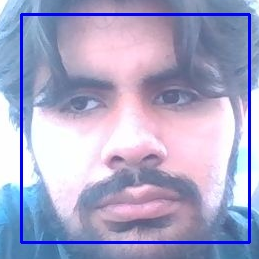

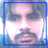

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,720,327
Trainable params: 14,719,303
Non-trainable params: 1,024
________________________________________

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


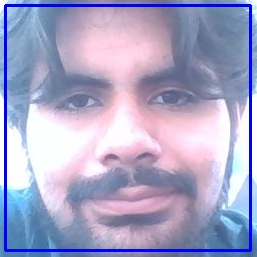

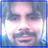

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,720,327
Trainable params: 14,719,303
Non-trainable params: 1,024
________________________________________

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


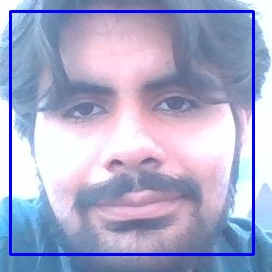

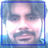

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,720,327
Trainable params: 14,719,303
Non-trainable params: 1,024
________________________________________

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


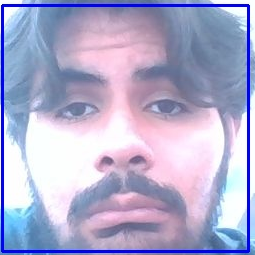

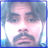

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,720,327
Trainable params: 14,719,303
Non-trainable params: 1,024
________________________________________

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


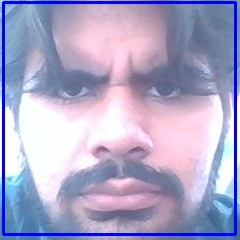

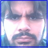

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,720,327
Trainable params: 14,719,303
Non-trainable params: 1,024
________________________________________

1/1 [==============================] - 0s 209ms/step
Variable is an array
[[0. 0. 0. 0. 0. 1. 0.]]
<class 'tuple'>
The key associated with the value is: Surprise
File '/content/cropped_face.jpg' Borrado exitosamente
File '/content/photo.jpg' Borrado exitosamente
['Surprise', 'Surprise', 'Happy', 'Surprise', 'Surprise']


In [14]:
arr_emotions= extract_emotions(time_loop=100)

In [15]:
print(arr_emotions)

['Surprise', 'Surprise', 'Happy', 'Surprise', 'Surprise']


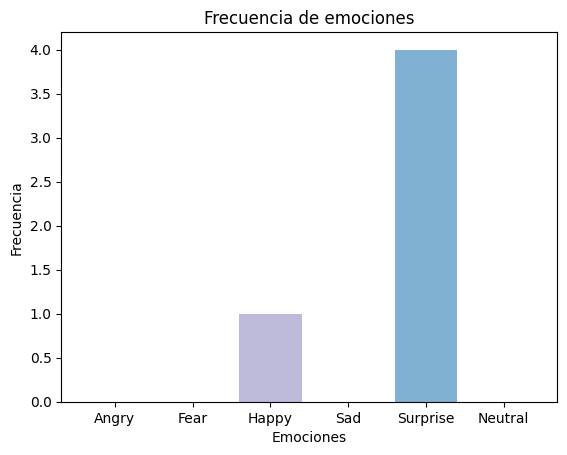

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import brewer2mpl

# emotion = {'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Surprise': 4, 'Neutral': 5}
emotion = {'Angry': 0, 'Disgust':1 ,'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}


arr_emotions = np.array(arr_emotions)

emotion_counts = {k: np.count_nonzero(arr_emotions == k) for k in emotion}

colors = brewer2mpl.get_map('Set3', 'qualitative', len(emotion)).mpl_colors

fig, ax = plt.subplots()
ax.bar(emotion_counts.keys(), emotion_counts.values(), color=colors)

ax.set_xlabel('Emociones')
ax.set_ylabel('Frecuencia')
ax.set_title('Frecuencia de emociones')

plt.show()
